# Late Fusion with Missing Modality Evaluation

This notebook evaluates late fusion performance when one modality is missing:
- Audio only (vision features set to zero)
- Vision only (audio features set to zero)
- Full fusion (both modalities)

The goal is to understand how the model performs when one modality is unavailable.


In [ ]:
# =============================================================================
# STEP 0: SETUP, LIBRARIES & DATA PREPARATION
# =============================================================================
import sys

# Use pip from current kernel's Python executable
print(f"Using pip from {sys.executable}...")

# Install required libraries
!{sys.executable} -m pip install matplotlib seaborn tqdm librosa pandas scikit-learn torchvision opencv-python -q
!{sys.executable} -m pip install transformers[torch] accelerate -q

print("--- All libraries installed! ---")

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import subprocess
import cv2
from PIL import Image
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


正在使用 /home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/bin/python 对应的pip进行安装...

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
--- 所有库安装完毕! ---


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


## Data Loading and Preparation

Load audio and vision data, ensuring consistent video_id matching for fusion.


In [ ]:
# =============================================================================
# STEP 1: LOAD DATA (Audio + Vision)
# =============================================================================

# Paths
RAVDESS_AUDIO_PATH = "/home/siyi/ravdess_audio"
RAVDESS_VIDEO_PATH = "/home/siyi/ravdess_dataset"
FRAMES_DIR = "/home/siyi/ravdess_frames"

# Emotion to sentiment mapping (same as both notebooks)
emotion_to_sentiment = {
    'neutral': 0,   # neutral
    'calm': 0,      # neutral
    'happy': 1,     # positive
    'surprised': 1, # positive
    'sad': 2,       # negative
    'angry': 2,     # negative
    'fearful': 2,   # negative
    'disgust': 2    # negative
}

ravdess_emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

sentiment_list = ['neutral', 'positive', 'negative']

# --- Load Audio Data ---
print("Loading audio data...")
audio_data = []
for filename in os.listdir(RAVDESS_AUDIO_PATH):
    if filename.endswith('.wav'):
        video_id = os.path.splitext(filename)[0]
        parts = video_id.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion:
                audio_data.append({
                    'video_id': video_id,
                    'audio_path': os.path.join(RAVDESS_AUDIO_PATH, filename),
                    'emotion': emotion,
                    'label': emotion_to_sentiment[emotion]
                })

audio_df = pd.DataFrame(audio_data)
audio_df = audio_df.sort_values('video_id').reset_index(drop=True)
print(f"✅ Loaded {len(audio_df)} audio files")

# --- Load Vision Data (frames) ---
print("Loading vision data...")
vision_data = []
for filename in os.listdir(FRAMES_DIR):
    if filename.endswith('.jpg'):
        # Extract video_id from frame filename (e.g., "01-01-01-01-01-01-01_frame_000.jpg")
        video_id = filename.split('_frame_')[0]
        parts = video_id.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion:
                vision_data.append({
                    'video_id': video_id,
                    'frame_path': os.path.join(FRAMES_DIR, filename),
                    'emotion': emotion,
                    'label': emotion_to_sentiment[emotion]
                })

vision_df = pd.DataFrame(vision_data)
print(f"✅ Loaded {len(vision_df)} vision frames")

# --- Group vision frames by video_id (collect all frames per video, same as single-modal) ---
vision_df_grouped = vision_df.groupby('video_id').agg({
    'frame_path': list,  # Collect all frame paths
    'emotion': 'first',  # Emotion label (same for all frames)
    'label': 'first'     # Label (same for all frames)
}).reset_index()

# Check number of frames per video
frames_per_video = vision_df_grouped['frame_path'].apply(len)
print(f"✅ Frames per video: min={frames_per_video.min()}, max={frames_per_video.max()}, mean={frames_per_video.mean():.1f}")
print(f"✅ Grouped to {len(vision_df_grouped)} unique videos")

# --- Merge audio and vision data by video_id ---
fusion_df = audio_df.merge(
    vision_df_grouped[['video_id', 'frame_path', 'emotion', 'label']],
    on='video_id',
    suffixes=('_audio', '_vision'),
    how='inner'
)

# Verify labels match
assert (fusion_df['label_audio'] == fusion_df['label_vision']).all(), "Label mismatch!"
fusion_df['label'] = fusion_df['label_audio']
fusion_df = fusion_df.drop(['label_audio', 'label_vision'], axis=1)

print(f"✅ Merged dataset: {len(fusion_df)} samples with both audio and vision")

# --- Split by actor ID (using audio notebook's split: train 1-16, val 17-21, test 22-24) ---
fusion_df['actor_id'] = fusion_df['video_id'].apply(lambda x: int(x.split('-')[-1]))

train_actor_ids = list(range(1, 19))
val_actor_ids = list(range(19, 22))
test_actor_ids = list(range(22, 25))

train_df = fusion_df[fusion_df['actor_id'].isin(train_actor_ids)].copy().reset_index(drop=True)
val_df = fusion_df[fusion_df['actor_id'].isin(val_actor_ids)].copy().reset_index(drop=True)
test_df = fusion_df[fusion_df['actor_id'].isin(test_actor_ids)].copy().reset_index(drop=True)

# Verify data split is correct
train_video_ids = set(train_df['video_id'].unique())
val_video_ids = set(val_df['video_id'].unique())
test_video_ids = set(test_df['video_id'].unique())

print(f"\n🔍 Data split verification:")
print(f"  Train videos: {len(train_video_ids)}")
print(f"  Val videos: {len(val_video_ids)}")
print(f"  Test videos: {len(test_video_ids)}")
print(f"  Train-Val overlap: {len(train_video_ids & val_video_ids)}")
print(f"  Train-Test overlap: {len(train_video_ids & test_video_ids)}")
print(f"  Val-Test overlap: {len(val_video_ids & test_video_ids)}")

if len(train_video_ids & val_video_ids) > 0 or len(train_video_ids & test_video_ids) > 0 or len(val_video_ids & test_video_ids) > 0:
    print("  ⚠️  WARNING: Data leakage detected!")
else:
    print("  ✅ No data leakage detected.")

print(f"\n📊 Data split:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Loading audio data...
✅ Loaded 2452 audio files
Loading vision data...
✅ Loaded 11428 vision frames
✅ Frames per video: min=4, max=5, mean=4.7
✅ Grouped to 2452 unique videos
✅ Merged dataset: 2452 samples with both audio and vision

🔍 Data split verification:
  Train videos: 1828
  Val videos: 312
  Test videos: 312
  Train-Val overlap: 0
  Train-Test overlap: 0
  Val-Test overlap: 0
  ✅ No data leakage detected.

📊 Data split:
Train: 1828 | Val: 312 | Test: 312


## Load Pre-trained Models and Extract Features

Load the pre-trained audio and vision models, modify them to extract features instead of classifications.


In [4]:
# =============================================================================
# STEP 2: LOAD PRE-TRAINED MODELS (Feature Extractors)
# =============================================================================

# --- Load Audio Model (Wav2Vec2) ---
print("Loading audio model (Wav2Vec2)...")
AUDIO_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/notebooks/best_wav2vec2_two_stage.pth"
MODEL_CHECKPOINT = "facebook/wav2vec2-base"
TARGET_SAMPLING_RATE = 16000

from transformers import AutoFeatureExtractor
audio_feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

# Load model
audio_model = AutoModelForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=3
).to(device)

# Load weights
if os.path.exists(AUDIO_MODEL_PATH):
    audio_model.load_state_dict(torch.load(AUDIO_MODEL_PATH, map_location=device))
    print("✅ Loaded audio model weights")
else:
    print("⚠️  Audio model weights not found, using pre-trained only")

# Freeze audio model and use as feature extractor
for param in audio_model.parameters():
    param.requires_grad = False
audio_model.eval()

# Get audio feature dimension
audio_feature_dim = audio_model.projector.out_features
print(f"Audio feature dimension: {audio_feature_dim}")

# --- Load Vision Model (ResNet50) ---
print("\nLoading vision model (ResNet50)...")
VISION_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/model_weights/resnet50_fer2013_sentiment.pth"

# Load ResNet50
vision_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes

# Move model to device BEFORE loading weights
vision_model = vision_model.to(device)

# Load weights
if os.path.exists(VISION_MODEL_PATH):
    vision_model.load_state_dict(torch.load(VISION_MODEL_PATH, map_location=device))
    print("✅ Loaded vision model weights")
else:
    print("⚠️  Vision model weights not found, using ImageNet pre-trained only")

# Freeze vision model and use as feature extractor
for param in vision_model.parameters():
    param.requires_grad = False
vision_model.eval()

# Create a feature extractor function for ResNet50
def extract_resnet_features(model, image):
    """Extract features from ResNet50 before the fc layer"""
    x = model.conv1(image)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    return x

# Get vision feature dimension
vision_feature_dim = num_ftrs  # 2048 for ResNet50
print(f"Vision feature dimension: {vision_feature_dim}")

# Total fused feature dimension
fused_feature_dim = audio_feature_dim + vision_feature_dim
print(f"\n✅ Total fused feature dimension: {fused_feature_dim} ({audio_feature_dim} + {vision_feature_dim})")


Loading audio model (Wav2Vec2)...


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded audio model weights
Audio feature dimension: 256

Loading vision model (ResNet50)...
✅ Loaded vision model weights
Vision feature dimension: 2048

✅ Total fused feature dimension: 2304 (256 + 2048)


## Dataset for Feature Extraction

Create dataset class to extract features from both modalities.


In [ ]:
# =============================================================================
# STEP 3: DATASET FOR FEATURE EXTRACTION
# =============================================================================

class FusionDataset(Dataset):
    """Dataset that extracts features from both audio and vision models"""
    
    def __init__(self, df, audio_model, vision_model, audio_feature_extractor, 
                 vision_transform, extract_resnet_fn, max_duration_s=5.0):
        self.df = df
        self.audio_model = audio_model
        self.vision_model = vision_model
        self.audio_feature_extractor = audio_feature_extractor
        self.vision_transform = vision_transform
        self.extract_resnet_fn = extract_resnet_fn
        self.max_length = int(max_duration_s * TARGET_SAMPLING_RATE)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path']
        frame_paths = row['frame_path']  
        label = row['label']
        
        
        if isinstance(frame_paths, str):
            frame_paths = [frame_paths]
        
        # Extract audio features
        try:
            audio, sr = librosa.load(audio_path, sr=None)
            if sr != TARGET_SAMPLING_RATE:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SAMPLING_RATE)
            
            audio_tensor = torch.tensor(audio).float()
            if len(audio_tensor) > self.max_length:
                audio_tensor = audio_tensor[:self.max_length]
            else:
                pad_len = self.max_length - len(audio_tensor)
                audio_tensor = torch.nn.functional.pad(audio_tensor, (0, pad_len))
            
            inputs = self.audio_feature_extractor(
                audio_tensor.numpy(),
                sampling_rate=TARGET_SAMPLING_RATE,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt"
            )
            
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.attention_mask.to(device)
            
            with torch.no_grad():
                audio_outputs = self.audio_model.wav2vec2(input_values, attention_mask=attention_mask)
                audio_features = audio_outputs.last_hidden_state.mean(dim=1)
                audio_features = self.audio_model.projector(audio_features)
                audio_features = audio_features.squeeze(0).cpu()
        except Exception as e:
            print(f"Error processing audio {audio_path}: {e}")
            audio_features = torch.zeros(audio_feature_dim)
        
        # Extract vision features from multiple frames
        vision_features_list = []
        for frame_path in frame_paths:
            try:
                image = Image.open(frame_path).convert('RGB')
                image = self.vision_transform(image).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    frame_features = self.extract_resnet_fn(self.vision_model, image)
                    vision_features_list.append(frame_features.squeeze(0).cpu())
            except Exception as e:
                print(f"Error processing vision frame {frame_path}: {e}")
                vision_features_list.append(torch.zeros(vision_feature_dim))
        
        # Average pool features from all frames
        if len(vision_features_list) > 0:
            vision_features = torch.stack(vision_features_list).mean(dim=0)
        else:
            vision_features = torch.zeros(vision_feature_dim)
        
        # Concatenate features
        fused_features = torch.cat([audio_features, vision_features], dim=0)
        
        return fused_features, audio_features, vision_features, label

# Vision transform
vision_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
print("Creating datasets...")
train_fusion_dataset = FusionDataset(train_df, audio_model, vision_model, 
                                     audio_feature_extractor, vision_transform, extract_resnet_features)
val_fusion_dataset = FusionDataset(val_df, audio_model, vision_model, 
                                   audio_feature_extractor, vision_transform, extract_resnet_features)
test_fusion_dataset = FusionDataset(test_df, audio_model, vision_model, 
                                    audio_feature_extractor, vision_transform, extract_resnet_features)

print("✅ Datasets created")


Creating datasets...
✅ Datasets created


## Extract Features and Apply PCA

Extract all features and apply PCA dimensionality reduction.


In [ ]:
# =============================================================================
# STEP 4: EXTRACT FEATURES AND APPLY PCA
# =============================================================================

print("Extracting features from all datasets...")

def extract_all_features(dataset):
    """Extract all features from a dataset"""
    all_fused_features = []
    all_audio_features = []
    all_vision_features = []
    all_labels = []
    
    for idx in tqdm(range(len(dataset)), desc="Extracting features"):
        fused_features, audio_features, vision_features, label = dataset[idx]
        all_fused_features.append(fused_features.numpy())
        all_audio_features.append(audio_features.numpy())
        all_vision_features.append(vision_features.numpy())
        all_labels.append(label)
    
    return (np.array(all_fused_features), np.array(all_audio_features), 
            np.array(all_vision_features), np.array(all_labels))

# Extract features from all datasets
print("\nExtracting training features...")
train_fused, train_audio, train_vision, train_labels = extract_all_features(train_fusion_dataset)
print(f"  Train fused features shape: {train_fused.shape}")
print(f"  Train audio features shape: {train_audio.shape}")
print(f"  Train vision features shape: {train_vision.shape}")

print("\nExtracting validation features...")
val_fused, val_audio, val_vision, val_labels = extract_all_features(val_fusion_dataset)
print(f"  Val fused features shape: {val_fused.shape}")

print("\nExtracting test features...")
test_fused, test_audio, test_vision, test_labels = extract_all_features(test_fusion_dataset)
print(f"  Test fused features shape: {test_fused.shape}")

# Apply PCA - fit on training set only
print("\n" + "="*60)
print("Applying PCA dimensionality reduction...")
print("="*60)

target_dim = min(512, len(train_fused) - 1, train_fused.shape[1])

pca = PCA(n_components=target_dim)
pca.fit(train_fused)

explained_variance_ratio = pca.explained_variance_ratio_.sum()
print(f"\n✅ PCA fitted on training set")
print(f"   Original dimension: {train_fused.shape[1]}")
print(f"   Reduced dimension: {target_dim}")
print(f"   Explained variance ratio: {explained_variance_ratio:.4f} ({explained_variance_ratio*100:.2f}%)")

# Transform all datasets
print("\nTransforming features...")
train_fused_pca = pca.transform(train_fused)
val_fused_pca = pca.transform(val_fused)
test_fused_pca = pca.transform(test_fused)

# =============================================================================
# SIMULATE MISSING MODALITY SCENARIOS
# =============================================================================
# Logic explanation (same as late_fusion_feature_concatenation.ipynb, but simulating missing modalities):
# 1. Full fusion: audio_features + vision_features (already concatenated in FusionDataset)
# 2. Vision missing (audio-only): replace vision features with zero vectors, concatenate as [audio_features, zeros(vision_dim)]
# 3. Audio missing (vision-only): replace audio features with zero vectors, concatenate as [zeros(audio_dim), vision_features]
# 4. All scenarios use the same PCA transform (fitted on full fusion features)
# 5. Use the same pre-trained fusion model for evaluation
# =============================================================================

# For audio-only (vision missing): concatenate audio features with zero vision features
# Vision missing: replace vision features with zero vectors, concatenate as [audio_features, zeros(vision_dim)]
train_audio_only = np.concatenate([train_audio, np.zeros((len(train_audio), vision_feature_dim))], axis=1)
val_audio_only = np.concatenate([val_audio, np.zeros((len(val_audio), vision_feature_dim))], axis=1)
test_audio_only = np.concatenate([test_audio, np.zeros((len(test_audio), vision_feature_dim))], axis=1)

# For vision-only (audio missing): concatenate zero audio features with vision features
# Audio missing: replace audio features with zero vectors, concatenate as [zeros(audio_dim), vision_features]
train_vision_only = np.concatenate([np.zeros((len(train_vision), audio_feature_dim)), train_vision], axis=1)
val_vision_only = np.concatenate([np.zeros((len(val_vision), audio_feature_dim)), val_vision], axis=1)
test_vision_only = np.concatenate([np.zeros((len(test_vision), audio_feature_dim)), test_vision], axis=1)

# Apply the same PCA transformation (fitted on full fusion features)
# Use the same PCA transform (fitted on full fusion features)
train_audio_only_pca = pca.transform(train_audio_only)
val_audio_only_pca = pca.transform(val_audio_only)
test_audio_only_pca = pca.transform(test_audio_only)

train_vision_only_pca = pca.transform(train_vision_only)
val_vision_only_pca = pca.transform(val_vision_only)
test_vision_only_pca = pca.transform(test_vision_only)

print(f"  Train fused after PCA: {train_fused_pca.shape}")
print(f"  Train audio-only after PCA: {train_audio_only_pca.shape}")
print(f"  Train vision-only after PCA: {train_vision_only_pca.shape}")

fused_feature_dim = target_dim
print(f"\n✅ Updated fused feature dimension: {fused_feature_dim}")


Extracting features from all datasets...

Extracting training features...


Extracting features:   0%|          | 0/1828 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 1828/1828 [16:27<00:00,  1.85it/s]


  Train fused features shape: (1828, 2304)
  Train audio features shape: (1828, 256)
  Train vision features shape: (1828, 2048)

Extracting validation features...


Extracting features: 100%|██████████| 312/312 [02:50<00:00,  1.83it/s]


  Val fused features shape: (312, 2304)

Extracting test features...


Extracting features: 100%|██████████| 312/312 [03:01<00:00,  1.72it/s]


  Test fused features shape: (312, 2304)

Applying PCA dimensionality reduction...

✅ PCA fitted on training set
   Original dimension: 2304
   Reduced dimension: 512
   Explained variance ratio: 0.9877 (98.77%)

Transforming features...
  Train fused after PCA: (1828, 512)
  Train audio-only after PCA: (1828, 512)
  Train vision-only after PCA: (1828, 512)

✅ Updated fused feature dimension: 512


## Create Datasets for Different Modality Scenarios

Create datasets for: full fusion, audio-only, and vision-only.


In [7]:
# =============================================================================
# STEP 5: CREATE DATASETS FOR DIFFERENT MODALITY SCENARIOS
# =============================================================================

class PCADataset(Dataset):
    """Dataset using pre-extracted PCA-reduced features"""
    
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets for full fusion
train_full = PCADataset(train_fused_pca, train_labels)
val_full = PCADataset(val_fused_pca, val_labels)
test_full = PCADataset(test_fused_pca, test_labels)

# Create datasets for audio-only
train_audio_only_ds = PCADataset(train_audio_only_pca, train_labels)
val_audio_only_ds = PCADataset(val_audio_only_pca, val_labels)
test_audio_only_ds = PCADataset(test_audio_only_pca, test_labels)

# Create datasets for vision-only
train_vision_only_ds = PCADataset(train_vision_only_pca, train_labels)
val_vision_only_ds = PCADataset(val_vision_only_pca, val_labels)
test_vision_only_ds = PCADataset(test_vision_only_pca, test_labels)

# Create dataloaders
batch_size = 32
train_loader_full = DataLoader(train_full, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_full = DataLoader(val_full, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_full = DataLoader(test_full, batch_size=batch_size, shuffle=False, num_workers=0)

train_loader_audio = DataLoader(train_audio_only_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_audio = DataLoader(val_audio_only_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_audio = DataLoader(test_audio_only_ds, batch_size=batch_size, shuffle=False, num_workers=0)

train_loader_vision = DataLoader(train_vision_only_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_vision = DataLoader(val_vision_only_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_vision = DataLoader(test_vision_only_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print("✅ Datasets and DataLoaders created for all scenarios")


✅ Datasets and DataLoaders created for all scenarios


## Load Pre-trained Fusion Model

Load the pre-trained fusion classifier model.


In [8]:
# =============================================================================
# STEP 6: LOAD PRE-TRAINED FUSION MODEL
# =============================================================================

class FusionClassifier(nn.Module):
    """Classifier for concatenated audio + vision features"""
    
    def __init__(self, input_dim, num_classes=3, hidden_dim=256, dropout=0.5):
        super(FusionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

# Load the pre-trained fusion model
FUSION_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/notebooks/best_fusion_classifier.pth"

fusion_model = FusionClassifier(
    input_dim=fused_feature_dim,
    num_classes=3,
    hidden_dim=256,
    dropout=0.5
).to(device)

if os.path.exists(FUSION_MODEL_PATH):
    fusion_model.load_state_dict(torch.load(FUSION_MODEL_PATH, map_location=device))
    print("✅ Loaded pre-trained fusion model")
else:
    print("⚠️  Pre-trained fusion model not found!")
    print("   Please train the model first using late_fusion_feature_concatenation.ipynb")

print(f"✅ Fusion model ready")
print(f"   Input dim: {fused_feature_dim}")
print(f"   Output dim: 3 (sentiment classes)")


✅ Loaded pre-trained fusion model
✅ Fusion model ready
   Input dim: 512
   Output dim: 3 (sentiment classes)


## Evaluation Function

Create a function to evaluate the model on different modality scenarios.


In [9]:
# =============================================================================
# STEP 7: EVALUATION FUNCTION
# =============================================================================

def evaluate_model(model, loader, scenario_name):
    """Evaluate model on a given loader and return metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in tqdm(loader, desc=f"Evaluating {scenario_name}"):
            features = features.to(device)
            outputs = model(features)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'predictions': all_preds,
        'labels': all_labels
    }


## Evaluate All Scenarios

Evaluate the model on test set with: full fusion, audio-only, and vision-only.


In [10]:
# =============================================================================
# STEP 8: EVALUATE ALL SCENARIOS
# =============================================================================

print("="*70)
print("EVALUATING MISSING MODALITY SCENARIOS")
print("="*70)

# Evaluate full fusion
print("\n" + "-"*70)
print("1. FULL FUSION (Audio + Vision)")
print("-"*70)
results_full = evaluate_model(fusion_model, test_loader_full, "Full Fusion")

# Evaluate vision-only
print("\n" + "-"*70)
print("2. VISION-ONLY (Audio features set to zero)")
print("-"*70)
results_vision = evaluate_model(fusion_model, test_loader_vision, "Vision-Only")

# Print comparison table
print("\n" + "="*70)
print("COMPARISON OF SCENARIOS")
print("="*70)

print(f"\n{'Scenario':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)
print(f"{'Full Fusion':<20} {results_full['accuracy']:<12.4f} {results_full['precision_macro']:<12.4f} {results_full['recall_macro']:<12.4f} {results_full['f1_macro']:<12.4f}")
print(f"{'Vision-Only':<20} {results_vision['accuracy']:<12.4f} {results_vision['precision_macro']:<12.4f} {results_vision['recall_macro']:<12.4f} {results_vision['f1_macro']:<12.4f}")

# Calculate performance drop
vision_drop = results_full['accuracy'] - results_vision['accuracy']

print("\n" + "="*70)
print("PERFORMANCE DROP ANALYSIS")
print("="*70)
print(f"Full Fusion Accuracy: {results_full['accuracy']:.4f} ({results_full['accuracy']*100:.2f}%)")
print(f"Vision-Only Accuracy: {results_vision['accuracy']:.4f} ({results_vision['accuracy']*100:.2f}%)")
print(f"  → Performance drop: {vision_drop:.4f} ({vision_drop*100:.2f} percentage points)")


EVALUATING MISSING MODALITY SCENARIOS

----------------------------------------------------------------------
1. FULL FUSION (Audio + Vision)
----------------------------------------------------------------------


Evaluating Full Fusion: 100%|██████████| 10/10 [00:00<00:00, 110.57it/s]



----------------------------------------------------------------------
2. VISION-ONLY (Audio features set to zero)
----------------------------------------------------------------------


Evaluating Vision-Only: 100%|██████████| 10/10 [00:00<00:00, 447.41it/s]


COMPARISON OF SCENARIOS

Scenario             Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
Full Fusion          0.8814       0.8832       0.8340       0.8541      
Vision-Only          0.7596       0.7167       0.6687       0.6842      

PERFORMANCE DROP ANALYSIS
Full Fusion Accuracy: 0.8814 (88.14%)
Vision-Only Accuracy: 0.7596 (75.96%)
  → Performance drop: 0.1218 (12.18 percentage points)


## Detailed Classification Reports

Print detailed classification reports for each scenario.


In [11]:
# =============================================================================
# STEP 9: DETAILED CLASSIFICATION REPORTS
# =============================================================================

print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

# Full Fusion Report
print("\n" + "-"*70)
print("1. FULL FUSION (Audio + Vision)")
print("-"*70)
print(classification_report(results_full['labels'], results_full['predictions'], 
                          target_names=sentiment_list))
print(f"Accuracy: {results_full['accuracy']:.4f}")
print(f"Macro F1: {results_full['f1_macro']:.4f}")

# Vision-Only Report
print("\n" + "-"*70)
print("2. VISION-ONLY (Audio features set to zero)")
print("-"*70)
print(classification_report(results_vision['labels'], results_vision['predictions'], 
                          target_names=sentiment_list))
print(f"Accuracy: {results_vision['accuracy']:.4f}")
print(f"Macro F1: {results_vision['f1_macro']:.4f}")



DETAILED CLASSIFICATION REPORTS

----------------------------------------------------------------------
1. FULL FUSION (Audio + Vision)
----------------------------------------------------------------------
              precision    recall  f1-score   support

     neutral       0.87      0.72      0.79        72
    positive       0.90      0.79      0.84        72
    negative       0.88      0.99      0.93       168

    accuracy                           0.88       312
   macro avg       0.88      0.83      0.85       312
weighted avg       0.88      0.88      0.88       312

Accuracy: 0.8814
Macro F1: 0.8541

----------------------------------------------------------------------
2. VISION-ONLY (Audio features set to zero)
----------------------------------------------------------------------
              precision    recall  f1-score   support

     neutral       0.69      0.53      0.60        72
    positive       0.65      0.51      0.57        72
    negative       0.81    

## Confusion Matrices

Visualize confusion matrices for all three scenarios.


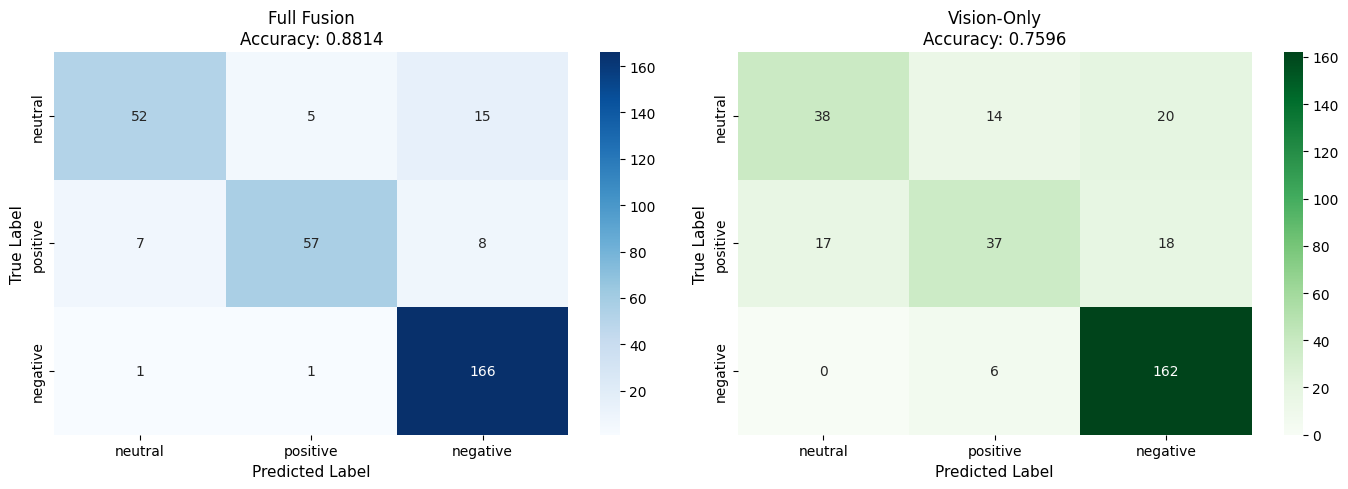

In [12]:
# =============================================================================
# STEP 10: CONFUSION MATRICES
# =============================================================================

# Create confusion matrices
cm_full = confusion_matrix(results_full['labels'], results_full['predictions'])
cm_vision = confusion_matrix(results_vision['labels'], results_vision['predictions'])

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full Fusion
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=sentiment_list, yticklabels=sentiment_list)
axes[0].set_title(f'Full Fusion\nAccuracy: {results_full["accuracy"]:.4f}', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Vision-Only
sns.heatmap(cm_vision, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=sentiment_list, yticklabels=sentiment_list)
axes[1].set_title(f'Vision-Only\nAccuracy: {results_vision["accuracy"]:.4f}', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()


## Performance Comparison Visualization

Create a bar chart comparing accuracy across all scenarios.


Evaluating Audio-Only scenario...


Evaluating Audio-Only: 100%|██████████| 10/10 [00:00<00:00, 203.54it/s]


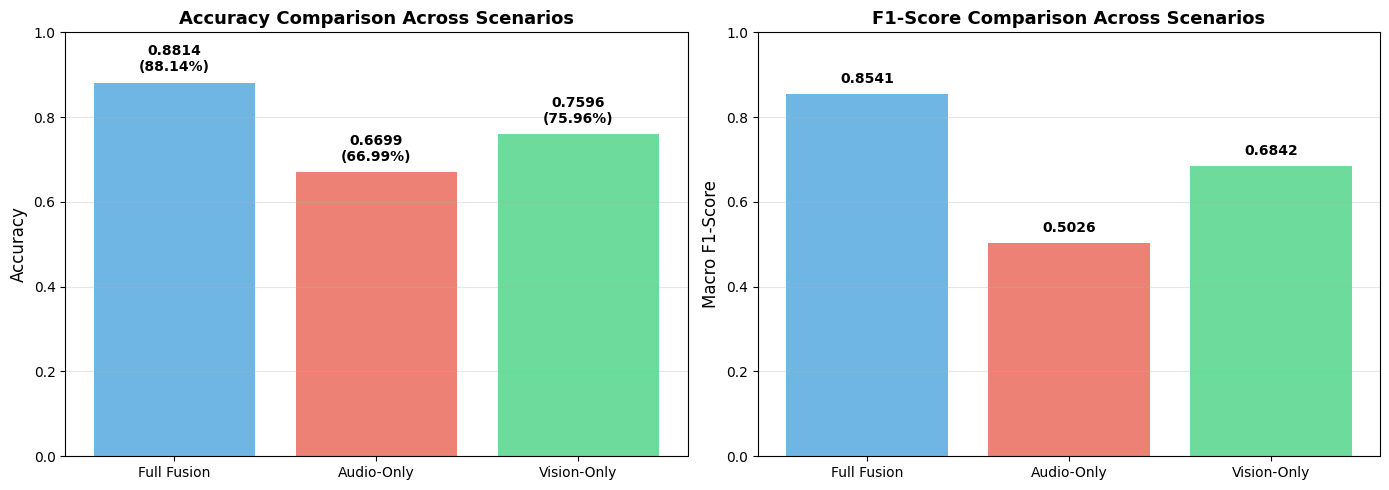


SUMMARY
Full Fusion provides the best performance: 0.8814 (88.14%)

When Vision is missing (Audio-Only):
  Accuracy: 0.6699 (66.99%)
  Performance drop: 0.2115 (21.15 percentage points)
  Relative drop: 24.00%

When Audio is missing (Vision-Only):
  Accuracy: 0.7596 (75.96%)
  Performance drop: 0.1218 (12.18 percentage points)
  Relative drop: 13.82%


In [13]:
# =============================================================================
# STEP 11: PERFORMANCE COMPARISON VISUALIZATION
# =============================================================================

# Evaluate audio-only if not already evaluated
if 'results_audio' not in locals():
    print("Evaluating Audio-Only scenario...")
    results_audio = evaluate_model(fusion_model, test_loader_audio, "Audio-Only")

# Prepare data for visualization
scenarios = ['Full Fusion', 'Audio-Only', 'Vision-Only']
accuracies = [results_full['accuracy'], results_audio['accuracy'], results_vision['accuracy']]
f1_scores = [results_full['f1_macro'], results_audio['f1_macro'], results_vision['f1_macro']]

# Create bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(scenarios, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison Across Scenarios', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 0.02, f'{acc:.4f}\n({acc*100:.2f}%)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1-Score comparison
axes[1].bar(scenarios, f1_scores, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
axes[1].set_ylabel('Macro F1-Score', fontsize=12)
axes[1].set_title('F1-Score Comparison Across Scenarios', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')
for i, f1 in enumerate(f1_scores):
    axes[1].text(i, f1 + 0.02, f'{f1:.4f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate performance drops
audio_drop = results_full['accuracy'] - results_audio['accuracy']
vision_drop = results_full['accuracy'] - results_vision['accuracy']

# Print summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Full Fusion provides the best performance: {results_full['accuracy']:.4f} ({results_full['accuracy']*100:.2f}%)")
print(f"\nWhen Vision is missing (Audio-Only):")
print(f"  Accuracy: {results_audio['accuracy']:.4f} ({results_audio['accuracy']*100:.2f}%)")
print(f"  Performance drop: {audio_drop:.4f} ({audio_drop*100:.2f} percentage points)")
print(f"  Relative drop: {(audio_drop/results_full['accuracy']*100):.2f}%")
print(f"\nWhen Audio is missing (Vision-Only):")
print(f"  Accuracy: {results_vision['accuracy']:.4f} ({results_vision['accuracy']*100:.2f}%)")
print(f"  Performance drop: {vision_drop:.4f} ({vision_drop*100:.2f} percentage points)")
print(f"  Relative drop: {(vision_drop/results_full['accuracy']*100):.2f}%")
